# MARATONA BEHIND THE CODE 2020

## DESAFIO 6 - ANAHUAC

### Introducción

En este desafio, usted usará herramientas de IBM como Watson Studio (o Cloud Pak for Data) para construir un modelo baseado en Machine Learning capaz de preveer si un estudante irá continuar o abandonará su curso.

<hr>

## Installing Libs

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install xgboost --upgrade

<hr>

## Loading the .csv dataset from GitHub

In [9]:
# A continuación importaremos varias bibliotecas que se utilizarán:

# Biblioteca para trabajar con JSON
import json

# Biblioteca para realizar solicitudes HTTP
import requests

# Biblioteca para exploración y análisis de datos
import pandas as pd

# Biblioteca con métodos numéricos y representaciones matriciales
import numpy as np

# Biblioteca para construir un modelo basado en la técnica Gradient Boosting
import xgboost as xgb

# Paquetes scikit-learn para preprocesamiento de datos
# "SimpleImputer" es una transformación para completar los valores faltantes en conjuntos de datos
from sklearn.impute import SimpleImputer

# Paquetes de scikit-learn para entrenamiento de modelos y construcción de pipelines
# Método para separar el conjunto de datos en muestras de testes y entrenamiento
from sklearn.model_selection import train_test_split
# Método para crear modelos basados en árboles de decisión
from sklearn.tree import DecisionTreeClassifier
# Clase para crear una pipeline de machine-learning
from sklearn.pipeline import Pipeline

# Paquetes scikit-learn para evaluación de modelos
# Métodos para la validación cruzada del modelo creado
from sklearn.model_selection import KFold, cross_validate

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import KNNImputer
import itertools

%matplotlib inline
def plot_confusion_matrix(y_true, y_pred, class_names,title="Confusion matrix",normalize=False,onehot = False, size=4):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    if onehot :
        cm = confusion_matrix([y_i.argmax() for y_i in y_true], [y_ip.argmax() for y_ip in y_pred])
    else:
        cm = confusion_matrix(y_true, y_pred)
    figure = plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2) if normalize else cm

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #return figure

In [2]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/ForTraining.csv
df_base_for_training = pd.read_csv(r'ForTraining.csv')
df_base_for_training.head()

,studentId,reducido,ciclo,Graduado
0,88588.0,Interv. Edu.,2019 - 08,No
1,81135.0,Educacion,2019 - 05,Si
2,80926.0,Direc. Estrat. Neg,2019 - 05,Si
3,82415.0,B. I.,2019 - 06,Si
4,90082.0,Est. Temprana,2019 - 08,No


Descripción: La primera tabla mostrada arriba tiene 4 columnas, 3 son features and el target: `Graduado` that has a binary values={Si, No}.

Usted puede, y debe, usar mas data que esta disponible para construir su modelo. Los siguientes archivos .csv presentados:

In [3]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/OrdenMaterias.csv
df_orden_materias = pd.read_csv(r'OrdenMaterias.csv')
df_orden_materias.head()

,reducido,2017 - 03,2017 - 04,2017 - 05,2017 - 06,2017 - 07,2017 - 08,2018 - 01,2018 - 02,2018 - 03,...,2019 - 05,2019 - 06,2019 - 07,2019 - 08,2020 - 01,2020 - 02,2020 - 03,2020 - 04,2020 - 05,2020 - 06
0,Act. Derecho Contratual,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Sin clase,Sin clase,Sin clase,Sin clase,Consentimiento y objeto digital contractual,Métodos alternos de resolución de controversias,Nueva clasificación contractual,Nuevo derecho probatorio documental,Contratos inteligentes,Consentimiento y objeto digital contractual
1,Adm. Emp.,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...
2,Adm. Riesgos,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones
3,Adm. Salud,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Calidad en salud,Contabilidad Financiera y Presupuestos,Administración de costos,Salud pública,Planeación estratégica en salud,Calidad en salud,Contabilidad Financiera y Presupuestos,Planeación estratégica en salud,Salud pública,Planeación estratégica en salud
4,Admon Fin.,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...


In [4]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaConexiones.csv
df_tabla_conexiones = pd.read_csv(r'TablaConexiones.csv')
df_tabla_conexiones.head()

,studentId,ciclo,Dias_Conectado,Minutos_Promedio,Minutos_Total
0,45870,2017 - 03,10.0,76.957000,769.57
1,45898,2017 - 03,32.0,370.231250,11847.40
2,45905,2017 - 03,50.0,198.717400,9935.87
3,45931,2017 - 03,22.0,294.535909,6479.79
4,45933,2017 - 03,18.0,177.991667,3203.85


In [5]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaTareas.csv
df_tabla_tareas = pd.read_csv(r'TablaTareas.csv')
df_tabla_tareas.describe()

,studentId,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
count,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000,6298.000000
mean,82465.858844,70.491830,8.909495,2.325500,0.185297,11.420292
std,12750.589042,28.568343,4.113840,3.878632,0.642416,3.158823
min,45870.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,75283.250000,63.815357,7.000000,0.000000,0.000000,10.000000
50%,83396.000000,81.538077,10.000000,0.000000,0.000000,11.000000
75%,92447.750000,90.222000,11.000000,3.000000,0.000000,14.000000
max,102590.000000,100.000000,29.000000,34.000000,11.000000,34.000000


# Feature Engineering

# Transformado la tabla Ordenmaterias

COn df_orden_materias.info(), verificamos que no existieran datos nulos, con ello podemos reemplazar todos los datos con 0 y 1s <br>
Con df_materias_count['reducido'].apply(lambda x : x.lower()).describe(include=['object']) verificamos que no existan reducidos repetidos en lower case or upper case
Hechos <br>
* No todas las materias son iguales de pasar
* cada materia tendrá un único identificador, sistema de datos categóricos

In [6]:
def transform_materias(df_materias):
    columns_ciclos = df_materias.columns.tolist()
    columns_ciclos.remove('reducido')
    df_materias_count = df_materias.copy()
    df_materias_count[columns_ciclos] = df_materias_count[columns_ciclos].applymap(lambda x: x.lower())
    df_materias_count[columns_ciclos] = df_materias_count[columns_ciclos].replace(to_replace=' ', value='', regex=True).replace(to_replace='sinclase', value='', regex=True)#.replace(to_replace='[A-Z/a-z]', value=1, regex=True)
    unique_materias = np.unique(df_materias_count[columns_ciclos].to_numpy().flatten()).tolist()
    df_materias_count[columns_ciclos] =df_materias_count[columns_ciclos].applymap(lambda x: unique_materias.index(x))
    df_materias_count = pd.melt(df_materias_count, id_vars=['reducido'], value_vars=columns_ciclos)
    df_materias_count.columns = ['reducido', 'ciclo', 'cursoid']
    df_materias_count['cursoid'] = df_materias_count['cursoid'].astype(str)
    return df_materias_count

df_materias = transform_materias(df_orden_materias)

df_materias.head()
# unique_materias = transform_materias(df_orden_materias)
# unique_materias = unique_materias.tolist()

,reducido,ciclo,cursoid
0,Act. Derecho Contratual,2017 - 03,0
1,Adm. Emp.,2017 - 03,0
2,Adm. Riesgos,2017 - 03,0
3,Adm. Salud,2017 - 03,0
4,Admon Fin.,2017 - 03,0


# Uniendo las tablas 

Con los cursos identificados ya podemos unir todas la tablas
* AL final no se consideraron la identidad de los cursos ya que no entregan datos relevantes para el problema, ademas de estar completamente desvalanceados y no contar con todos los existentes en el entrenamiento como en los datos de prueba
* Se cambio a identidad numérica la caracteristica 'reducido' 

In [111]:
def add_data2base(base, tareas, conexiones, materias,trainbase ):
    # Estado de estudiantes + responsabilidades micro
    merge0 = base.merge(tareas, how='left', left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],right_index=False,)

    # merge + tabla de conexiones
    merge1 = merge0.merge(conexiones, how='left', left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],right_index=False,)

    # merge + Materia cursada
    data_ = merge1#.merge(materias, how='left', left_on=['reducido', 'ciclo'], right_on=['reducido', 'ciclo'],right_index=False,)
    columns = data_.columns.tolist()
    if 'Graduado' in columns:
        data_ = data_.drop(columns=['Graduado']).join(data_['Graduado'])
    
    # Cambiando a numeración sencilla los reducido
    unique_reducidos = np.unique(trainbase['reducido'].to_numpy().flatten()).tolist()
    data_['reducido'] =data_['reducido'].apply(lambda x: unique_reducidos.index(x))
    
        
    # Cambiando tipo de dato a cursoid
    #data_['cursoid'] = data_['cursoid'].astype(str)
    data_['reducido'] = data_['reducido'].astype(str)
    
    return data_


df_train = add_data2base(base=df_base_for_training, tareas=df_tabla_tareas, conexiones=df_tabla_conexiones, materias=df_materias ,trainbase = df_base_for_training )
df_train.head()

,studentId,reducido,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,Graduado
0,88588.0,59,2019 - 08,71.288667,13.0,2.0,0.0,15.0,28.0,371.757500,10409.21,No
1,81135.0,37,2019 - 05,90.000000,10.0,0.0,0.0,10.0,182.0,328.250934,59741.67,Si
2,80926.0,29,2019 - 05,90.606364,11.0,0.0,0.0,11.0,118.0,244.264661,28823.23,Si
3,82415.0,5,2019 - 06,88.000000,9.0,1.0,0.0,10.0,32.0,543.530313,17392.97,Si
4,90082.0,40,2019 - 08,25.454545,3.0,8.0,0.0,11.0,14.0,308.148571,4314.08,No


# UPsampling Data
Se observa que una de las clases está desbalanceada

In [112]:
count4bal = df_train['Graduado'].value_counts().sort_values(ascending=True)
class_sorter = count4bal.index.tolist()[:-1]
class_mayor = count4bal.index[-1]
mayority_sample = count4bal[-1]
df_balanced = df_train.loc[df_train['Graduado']==class_mayor]
for class_i in class_sorter:
    df_minor_upsampled = resample(df_train.loc[df_train['Graduado']==class_i], 
                             replace=True,     # sample with replacement
                             n_samples=mayority_sample,    # to match majority class
                             random_state=17) # reproducible results

    df_balanced = pd.concat([df_balanced,df_minor_upsampled ],ignore_index=True)
df_balanced['Graduado'].value_counts()

Si    1280
No    1280
Name: Graduado, dtype: int64

# Agregando caracteristicas

* Ratio de eficiancia en entrega de tareas [puntual+retraso]/[total]
* Penalizar la nota promedio con el ratio de eficiencia de las tareas cumplidas [calificacion_promedio]*[ratio]
* Ratio de Minutos conectados [minutos_total]/[PROMEDIO_DIAS] según Reducido
* Ratio de Dias conectados [Dias_conectado]/[PROMEDIO_DIAS ] según Reducido
* Ratio de Minutos promedio [Minutos_promedio]/[Promedio de minutos promedio] según reducido

In [113]:
def add_new_features(data,train_data):
    # Obteniendo la media según REDUCIDO de 'Minutos_Promedio','Minutos_Total','Dias_Conectado'
    df_mean_time = train_data.copy()#loc[df_train['Graduado']=='Si']
    df_mean_time = df_mean_time[['reducido','Minutos_Promedio','Minutos_Total','Dias_Conectado'] ].groupby(['reducido']).mean()#.sort_values(by='Minutos_Promedio', ascending=True )
    #df_mean_time.loc['37']['Minutos_Promedio']

    def eficien_rates(x):
        r_efic = (x['Tareas_Puntuales']+x['Tareas_Retrasadas']*.5)/x['Total_Tareas']
        calf_r = x['Calificacion_Promedio']*r_efic
        r_min_con = x['Minutos_Total']/df_mean_time.loc[x['reducido']]['Minutos_Total']
        r_dias_con = x['Dias_Conectado']/df_mean_time.loc[x['reducido']]['Dias_Conectado']
        r_minP_con = x['Minutos_Promedio']/df_mean_time.loc[x['reducido']]['Minutos_Promedio']

        return pd.Series([r_efic,calf_r,r_min_con,r_dias_con,r_minP_con ], index = ['r_efic','calf_r','r_min_con','r_dias_con','r_minP_con'])

    return data.join(data.apply(eficien_rates, axis=1))

df_balanced_improve =  add_new_features(df_balanced.copy(), train_data = df_train)
df_balanced_improve.head()

,studentId,reducido,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,Graduado,r_efic,calf_r,r_min_con,r_dias_con,r_minP_con
0,81135.0,37,2019 - 05,90.000000,10.0,0.0,0.0,10.0,182.0,328.250934,59741.67,Si,1.000000,90.000000,4.811636,3.473684,1.361626
1,80926.0,29,2019 - 05,90.606364,11.0,0.0,0.0,11.0,118.0,244.264661,28823.23,Si,1.000000,90.606364,2.863685,2.874043,1.031623
2,82415.0,5,2019 - 06,88.000000,9.0,1.0,0.0,10.0,32.0,543.530313,17392.97,Si,0.900000,79.200000,1.474038,0.581818,2.233279
3,76347.0,23,2019 - 03,88.428667,15.0,0.0,0.0,15.0,109.0,243.157431,26504.16,Si,1.000000,88.428667,2.313188,2.609576,0.879741
4,70566.0,72,2019 - 01,89.630000,8.0,0.0,1.0,9.0,97.0,214.730412,20828.85,Si,0.944444,84.650556,1.688892,1.977670,0.794726


# Buscando posibles valores nulos

No se ha encontrado ningun valor nulo

In [66]:
df_balanced_improve.isnull().sum()

studentId                0
reducido                 0
ciclo                    0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
Graduado                 0
r_efic                   0
calf_r                   0
r_min_con                0
r_dias_con               0
r_minP_con               0
dtype: int64

In [67]:
df_balanced_improve.describe(include=['object'])

,reducido,ciclo,Graduado
count,2560,2560,2560
unique,87,22,2
top,4,2019 - 08,Si
freq,270,353,1280


# Escalando Valores

In [68]:
n_components = 12 #n_components
scaler = MinMaxScaler()
columns_float = df_balanced_improve.columns.tolist()
columns_float.remove('reducido') 
columns_float.remove('Graduado') 
columns_float.remove('ciclo') 
columns_float.remove('studentId') 

scaler.fit(df_balanced_improve[columns_float])
df_balanced_improve[columns_float] = scaler.transform(df_balanced_improve[columns_float])
df_balanced_improve.head()

,studentId,reducido,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,Graduado,r_efic,calf_r,r_min_con,r_dias_con,r_minP_con
0,81135.0,37,2019 - 05,0.900000,0.344828,0.000000,0.000,0.172414,0.914141,0.281527,0.557054,Si,1.000000,0.900000,0.597414,0.724033,0.290838
1,80926.0,29,2019 - 05,0.906064,0.379310,0.000000,0.000,0.206897,0.590909,0.209496,0.268759,Si,1.000000,0.906064,0.355556,0.598395,0.220350
2,82415.0,5,2019 - 06,0.880000,0.310345,0.029412,0.000,0.172414,0.156566,0.466163,0.162179,Si,0.900000,0.792000,0.183017,0.118123,0.477019
3,76347.0,23,2019 - 03,0.884287,0.517241,0.000000,0.000,0.344828,0.545455,0.208546,0.247135,Si,1.000000,0.884287,0.287206,0.542983,0.187909
4,70566.0,72,2019 - 01,0.896300,0.275862,0.000000,0.125,0.137931,0.484848,0.184165,0.194216,Si,0.944444,0.846506,0.209693,0.410585,0.169750


# ELiminando columnas
* Se observa que la columna ciclo ya no tiene utilidad y al parecer es un dato aleatorio, ya que solo es temporal
* No se cuenta con una data extensa que pueda mostrar una tendencia en el tiempo

In [69]:
df_balanced_improve_drop = df_balanced_improve.drop(columns=['ciclo','studentId'])

# Generando Tabla base para el ONEHOT

In [126]:
unique_reducidos = np.unique(df_balanced_improve_drop['reducido'].to_numpy().flatten()).tolist()

df_reducido = pd.DataFrame(data =unique_reducidos, columns = ['reducido'] ).astype(str)

onehot_base_table = df_reducido.join(pd.get_dummies( df_reducido))
onehot_base_table.head()

,reducido,reducido_0,reducido_1,reducido_10,reducido_11,reducido_12,reducido_13,reducido_14,reducido_15,reducido_16,...,reducido_8,reducido_80,reducido_81,reducido_82,reducido_83,reducido_84,reducido_85,reducido_86,reducido_87,reducido_9
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Transformando Valores con ONEHOT

In [151]:
X_train = pd.get_dummies(df_balanced_improve_drop.drop(columns=['Graduado']))
y_train = df_balanced_improve['Graduado']
X_train.head()

,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,r_efic,calf_r,...,reducido_8,reducido_80,reducido_81,reducido_82,reducido_83,reducido_84,reducido_85,reducido_86,reducido_87,reducido_9
0,0.900000,0.344828,0.000000,0.000,0.172414,0.914141,0.281527,0.557054,1.000000,0.900000,...,0,0,0,0,0,0,0,0,0,0
1,0.906064,0.379310,0.000000,0.000,0.206897,0.590909,0.209496,0.268759,1.000000,0.906064,...,0,0,0,0,0,0,0,0,0,0
2,0.880000,0.310345,0.029412,0.000,0.172414,0.156566,0.466163,0.162179,0.900000,0.792000,...,0,0,0,0,0,0,0,0,0,0
3,0.884287,0.517241,0.000000,0.000,0.344828,0.545455,0.208546,0.247135,1.000000,0.884287,...,0,0,0,0,0,0,0,0,0,0
4,0.896300,0.275862,0.000000,0.125,0.137931,0.484848,0.184165,0.194216,0.944444,0.846506,...,0,0,0,0,0,0,0,0,0,0


# Transform Test DATA

In [152]:
# Test DATA
df_to_be_predicted = pd.read_csv(r'ToBePredicted.csv')

# Uniendo tablas
df_temp = add_data2base(base=df_to_be_predicted, tareas=df_tabla_tareas, conexiones=df_tabla_conexiones, materias=df_materias ,trainbase = df_base_for_training  )

# Agregando caracteristicas
df_temp =  add_new_features(df_temp.copy(), train_data = df_train)

# Escalando caracteristicas
df_temp[columns_float] = scaler.transform(df_temp[columns_float])

# Cambiando a HONEHOT 'reducido'
df_temp1 = df_temp.merge(onehot_base_table, how='left', left_on=['reducido'], right_on=['reducido'],right_index=False,)
#df_temp1 = df_temp.join(onehot_base_table.set_index('reducido'), on='reducido')

# Eliminando columnas
df_test = df_temp1.drop(columns=['ciclo','studentId','reducido'])
df_test.head()

,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,r_efic,calf_r,...,reducido_8,reducido_80,reducido_81,reducido_82,reducido_83,reducido_84,reducido_85,reducido_86,reducido_87,reducido_9
0,0.928000,0.172414,0.000000,0.0,0.000000,0.308081,0.182105,0.122749,1.000000,0.928000,...,0,0,0,0,0,0,0,0,0,0
1,0.188889,0.068966,0.205882,0.0,0.137931,0.040404,0.214957,0.021033,0.222222,0.041975,...,0,0,0,0,0,0,0,0,0,0
2,0.859000,0.344828,0.000000,0.0,0.172414,0.237374,0.472416,0.246531,1.000000,0.859000,...,0,0,0,0,0,0,0,0,0,0
3,0.661333,0.413793,0.088235,0.0,0.344828,0.101010,0.157436,0.035944,0.800000,0.529067,...,0,0,0,0,0,0,0,0,0,0
4,0.980000,0.344828,0.000000,0.0,0.172414,0.439394,0.069090,0.066101,1.000000,0.980000,...,0,0,0,0,0,0,0,0,0,0


# Todas las columnas son iguales tanto en el TEST como en el TRAIN
* Se comprueba que todas las columnas son iguales y en el mismo orden

In [153]:
for train, test in zip(df_test.columns.tolist(), X_train.columns.tolist()):
    assert train == test, '{} no es igual a {}'.format(train, test)
print("TODAS LAS COLUMNAS SON IGUALES")

TODAS LAS COLUMNAS SON IGUALES


# No valores nulos en el test
* No existen valores nulos en el test

In [154]:
null_count = df_test.isnull().sum() #info()#.loc[df_test['reducido_8'] !=df_test['reducido_8'] ]
null_count[null_count>0]

Series([], dtype: int64)

# MODEL TIME

In [20]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV,StratifiedKFold
#from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score,confusion_matrix
#from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
#from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from collections import defaultdict
from sklearn.metrics import classification_report

from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
best_parameters = defaultdict(list) # 'xgb': XGBClassifier(),
classifiers = defaultdict(list)
# X_train       = df_balanced_improve.drop(columns=['PROFILE']).to_numpy()
# y_train       = df_balanced_improve['PROFILE']

In [43]:
##NOTA:
# El metodo df_catdumm (cat+PCA+scalar) no sirve, entrega un pesimo rendimiento        F1 = 0.64
# EL metodo df_cat (usar bandas -10 para agrupar valores) entregó un rendimiento medio F1=0.81
# EL método df_balanced entregó un rendimiento de F1 = 0.93
# X_train       = df_balanced.drop(columns=['PROFILE'])
# y_train       = df_balanced['PROFILE']


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
# Parameters to tune
# SVC_simple
tuned_parameters_svcL = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 'auto','scale'],'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# SVC
tuned_parameters_svc = [{'penalty': ['l2','l1'], 'loss': ['squared_hinge','hinge'],'C': [0.01,0.1,1.0,10], 'max_iter': [4000], 'random_state':[15], 'dual':[False]}]

# XGB
tuned_parameters_xgb = [{'learning_rate':[0.3,0.01],'n_estimators':[50,70,80,90,100],'min_child_weight':[.01],'subsample':[.5,.8,1.0],'colsample_bytree':[0.5],
                    'objective':['multi:softmax','binary:logistic'],'n_jobs':[-1],'random_state':[15] },
                    {'learning_rate':[0.2,0.02],'n_estimators':[50,70,80,90,100],'min_child_weight':[.01],'subsample':[.5,.8,1.0],'colsample_bytree':[0.5],
                    'objective':['binary:logistic', 'multi:softmax'],'n_jobs':[-1],'random_state':[15] }]
#KNC
tuned_parameters_knc = [{'n_neighbors':[2,4,6,8,10,12],'n_jobs':[-1],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'p':[1,2]}]

#RFC
tuned_parameters_rfc = [{'n_estimators':[80,100,120,140,160],'criterion':['gini','entropy'],'min_samples_split':[1,2,3,4,5],'n_jobs':[-1],'random_state':[15]}]

#GBC
tuned_parameters_gbc = [{'loss':['deviance','exponential'],'learning_rate':[0.1,0.01],'n_estimators':[80,100,120],'subsample':[.8,1.0],'criterion':[ 'mse','friedman_mse'],'max_depth':[3,5,8,10],'random_state':[15]}]

#ETC
tuned_parameters_etc = [{ 'min_samples_split':[.2,.4,.8], 'n_estimators':[80,100,150],'warm_start':[True],'bootstrap':[True],
                         'n_jobs':[-1], 'random_state':[15], 'min_samples_leaf':[3,4,5,6] ,'criterion':['gini', 'entropy'],'max_features':[ 'sqrt']   }]

#LR
tuned_parameters_lr = [{'C':[0.1,1.0,10.0], 'dual':[False], 'solver':['newton-cg', 'saga','sag'],'multi_class':['ovr', 'multinomial']}]

# Parameter tunning
scores = ['f1']

# Best parameters

models = {'lr': LR(random_state=17), 'xgb': XGBClassifier(), 'svc':LinearSVC(), 'svcL': SVC(), 'rfc':RandomForestClassifier(), 'knc': KNC(),'etc':ExtraTreesClassifier() ,'gbc':GradientBoostingClassifier() }
parameters = {'lr':tuned_parameters_lr, 'xgb': tuned_parameters_xgb, 'knc': tuned_parameters_knc,'rfc':tuned_parameters_rfc,'svc':tuned_parameters_svc, 'svcL':tuned_parameters_svcL, 'gbc':tuned_parameters_gbc, 'etc':tuned_parameters_etc }

#;ista = ['etc']
for model_name in models.keys():
    print("######### MODEL tunning hyper-parameters for %s" % model_name)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s ###############################################################" % (model_name, score))
        clf_i = GridSearchCV(models[model_name], parameters[model_name], scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters[model_name] = clf_i.best_params_
        classifiers[model_name] = clf_i
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed classification report:")
        print("CV - Results max score: {}".format(np.nan_to_num( means).max()))
        print()
        y_true, y_pred = y_train, clf_i.predict(X_train)
        print(classification_report(y_true, y_pred, digits=4 ))

######### MODEL tunning hyper-parameters for lr
# lr - Tuning hyper-parameters for f1 ###############################################################
Best parameters set found on development set:

{'C': 1.0, 'dual': False, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Grid scores on development set:

Detailed classification report:
CV - Results max score: 0.8001097416279922

              precision    recall  f1-score   support

          No     0.8404    0.7859    0.8123      1280
          Si     0.7990    0.8508    0.8241      1280

    accuracy                         0.8184      2560
   macro avg     0.8197    0.8184    0.8182      2560
weighted avg     0.8197    0.8184    0.8182      2560

######### MODEL tunning hyper-parameters for xgb
# xgb - Tuning hyper-parameters for f1 ###############################################################
Best parameters set found on development set:

{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 0.01, 'n_estimators':

In [45]:
best_parameters = defaultdict(list,
            {'lr': {'C': 1.0,
              'dual': False,
              'multi_class': 'multinomial',
              'solver': 'newton-cg'},
             'xgb': {'colsample_bytree': 0.5,
              'learning_rate': 0.2,
              'min_child_weight': 0.01,
              'n_estimators': 80,
              'n_jobs': -1,
              'objective': 'binary:logistic',
              'random_state': 15,
              'subsample': 0.8},
             'svc': {'C': 0.1,
              'dual': False,
              'loss': 'squared_hinge',
              'max_iter': 4000,
              'penalty': 'l1',
              'random_state': 15},
             'svcL': {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'},
             'rfc': {'criterion': 'entropy',
              'min_samples_split': 3,
              'n_estimators': 100,
              'n_jobs': -1,
              'random_state': 15},
             'knc': {'algorithm': 'auto',
              'n_jobs': -1,
              'n_neighbors': 2,
              'p': 2},
             'etc': {'bootstrap': True,
              'criterion': 'entropy',
              'max_features': 'sqrt',
              'min_samples_leaf': 3,
              'min_samples_split': 0.2,
              'n_estimators': 100,
              'n_jobs': -1,
              'random_state': 15,
              'warm_start': True},
             'gbc': {'criterion': 'mse',
              'learning_rate': 0.1,
              'loss': 'exponential',
              'max_depth': 8,
              'n_estimators': 120,
              'random_state': 15,
              'subsample': 0.8}})

# Bagging Classifier MODEL - GRIDSEARCH + CV

In [46]:
clf_gbc = GradientBoostingClassifier(**best_parameters['gbc'] )#n_estimators=80, n_jobs=-1)# 20 - 80
clf_RFC = RandomForestClassifier(**best_parameters['rfc'] )#
clf_KNC = KNC(**best_parameters['knc'] )
xgb_model = XGBClassifier(**best_parameters['xgb'])
svc = LinearSVC(**best_parameters['svc'])
svcL = SVC(**best_parameters['svcL'])
etc = ExtraTreesClassifier(**best_parameters['etc'])
lr  = LR(**best_parameters['lr'])

models = {'gbc': clf_gbc, 'rfc':clf_RFC, 'knc': clf_KNC, 'xgb':xgb_model,  'svc':svc, 'svcL':svcL, 'etc':etc,'lr':lr }

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
# Parameter tunning
scores = ['f1']
# Best parameters
best_parameters_bagging = defaultdict(list)
#lista = ['etc']
for model_name in models.keys():
    params_bagging = [{'n_estimators': [10,50,100,150], 'max_samples':[1.0],'base_estimator': [models[model_name]],'n_jobs':[-1] }]
    print("######### Bagging MODEL tunning hyper-parameters for %s" % model_name)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s #########################################################" % (model_name, score))
        clf_i = GridSearchCV(BaggingClassifier(), params_bagging, scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters_bagging[model_name] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed Bagging classification report:")
        print("CV - Results max score: {}".format(np.nan_to_num( means).max()))
        print()
        y_true, y_pred = y_train, clf_i.predict(X_train)
        print(classification_report(y_true, y_pred, digits=4))

######### Bagging MODEL tunning hyper-parameters for gbc
# gbc - Tuning hyper-parameters for f1 #########################################################
Best parameters set found on development set:

{'base_estimator': GradientBoostingClassifier(criterion='mse', loss='exponential', max_depth=8,
                           n_estimators=120, random_state=15, subsample=0.8), 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': -1}
Grid scores on development set:

Detailed Bagging classification report:
CV - Results max score: 0.875372574824697

              precision    recall  f1-score   support

          No     0.9969    0.9891    0.9929      1280
          Si     0.9891    0.9969    0.9930      1280

    accuracy                         0.9930      2560
   macro avg     0.9930    0.9930    0.9930      2560
weighted avg     0.9930    0.9930    0.9930      2560

######### Bagging MODEL tunning hyper-parameters for rfc
# rfc - Tuning hyper-parameters for f1 ################################

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'base_estimator': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=None,
              min_child_weight=0.01, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=-1, num_parallel_tree=None,
              random_state=15, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None), 'max_samples': 1.0, 'n_estimators': 150, 'n_jobs': -1}
Grid scores on development set:

Detailed Bagging classification report:
CV - Results max score: 0.8628615555495976

              precision    recall  f1-score   support

          No     0.9912    0.9711    0.9811      1280
          Si     0.9717    0

In [47]:
best_parameters_bagging = defaultdict(list,
            {'gbc': {'base_estimator': GradientBoostingClassifier(**best_parameters['gbc'] ),
              'max_samples': 1.0,
              'n_estimators': 50,
              'n_jobs': -1},
             'rfc': {'base_estimator': RandomForestClassifier(**best_parameters['rfc'] ),
              'max_samples': 1.0,
              'n_estimators': 150,
              'n_jobs': -1},
             'knc': {'base_estimator': KNC(**best_parameters['knc'] ),
              'max_samples': 1.0,
              'n_estimators': 50,
              'n_jobs': -1},
             'xgb': {'base_estimator': XGBClassifier(**best_parameters['xgb']),
              'max_samples': 1.0,
              'n_estimators': 150,
              'n_jobs': -1},
             'svc': {'base_estimator': LinearSVC(**best_parameters['svc']),
              'max_samples': 1.0,
              'n_estimators': 100,
              'n_jobs': -1},
             'svcL': {'base_estimator': SVC(**best_parameters['svcL']),
              'max_samples': 1.0,
              'n_estimators': 150,
              'n_jobs': -1},
             'etc': {'base_estimator': ExtraTreesClassifier(**best_parameters['etc']),
              'max_samples': 1.0,
              'n_estimators': 150,
              'n_jobs': -1},
             'lr': {'base_estimator': LR(**best_parameters['lr']),
              'max_samples': 1.0,
              'n_estimators': 100,
              'n_jobs': -1}})

defaultdict(list,
            {'gbc': {'base_estimator': GradientBoostingClassifier(criterion='mse', loss='exponential', max_depth=8,
                                         n_estimators=120, random_state=15, subsample=0.8),
              'max_samples': 1.0,
              'n_estimators': 50,
              'n_jobs': -1},
             'rfc': {'base_estimator': RandomForestClassifier(criterion='entropy', min_samples_split=3, n_jobs=-1,
                                     random_state=15),
              'max_samples': 1.0,
              'n_estimators': 150,
              'n_jobs': -1},
             'knc': {'base_estimator': KNeighborsClassifier(n_jobs=-1, n_neighbors=2),
              'max_samples': 1.0,
              'n_estimators': 50,
              'n_jobs': -1},
             'xgb': {'base_estimator': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                            colsample_bynode=None, colsample_bytree=0.5, gamma=None,
                            gpu_

# Improved Models

Dependiendo de los resultados del bagging debemos elegir si quedarnos o no el modelo en bagging

In [48]:
xgb_f = XGBClassifier(**best_parameters['xgb'])
KNC_f = BaggingClassifier( **best_parameters_bagging['knc'] )
RFC_f = RandomForestClassifier(**best_parameters['rfc'] )
svc_f = BaggingClassifier( **best_parameters_bagging['svc'] )
svcL_f= BaggingClassifier( **best_parameters_bagging['svcL'] )
gbc_f = GradientBoostingClassifier(**best_parameters['gbc'] )
etc_f = ExtraTreesClassifier(**best_parameters['etc'])
lr_f  = BaggingClassifier( **best_parameters_bagging['lr'] )

# Voting Classifier Model + GridSerch

In [52]:
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score #( X_train_PCA , label)
from sklearn.metrics import f1_score
# Ir retirnando los modelos más deviles progresivamente
estimators0= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('svc',svc_f),('svcL',svcL_f),('gbc',gbc_f),('etc',etc_f),('lr', lr_f)]
estimators1= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('svcL',svcL_f),('gbc',gbc_f),('etc',etc_f),('lr', lr_f)]
estimators2= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('gbc',gbc_f),('etc',etc_f),('lr', lr_f)]
estimators3= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('gbc',gbc_f),('etc',etc_f)]
estimators4= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('gbc',gbc_f)]
estimators5= [ ('xgb', xgb_f),('rfc',RFC_f),('gbc',gbc_f)] # **** ganador 
estimators6= [ ('rfc',RFC_f),('gbc',gbc_f)]

estimators = [ estimators0,estimators1,estimators2,estimators3,estimators4,estimators5,estimators6]
voting = ['hard','soft']

params_voting = [{'voting':voting,'n_jobs':[-1] }] # 'estimators': estimators, 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
# Parameter tunning
scores = ['f1']
# Best parameters
best_parameters_voting = defaultdict(list)
# Scores
score_f1 = []

print("######### Voting MODEL tunning hyper-parameters for %s" % model_name)
for ind , set_estimator in enumerate(estimators):
    model_vc_i = VotingClassifier(estimators = set_estimator)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s #############################################################" % ('Voting', score))
        clf_i = GridSearchCV(model_vc_i, params_voting, scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters_voting['set'+str(ind)] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
    #         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
    #             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed Bagging classification report:")
        print("CV - Results max score: {}".format(np.nan_to_num( means).max()))
        score_f1.append(np.nan_to_num( means).max())
        best_parameters_voting['scores'] = score_f1
        print()
        #y_true, y_pred = y_train, clf_i.predict(X_train)
        #print(classification_report(y_true, y_pred, digits=4))

######### Voting MODEL tunning hyper-parameters for lr
# Voting - Tuning hyper-parameters for f1 #############################################################
Best parameters set found on development set:

{'n_jobs': -1, 'voting': 'hard'}
Grid scores on development set:

Detailed Bagging classification report:
CV - Results max score: 0.858187608904381

# Voting - Tuning hyper-parameters for f1 #############################################################
Best parameters set found on development set:

{'n_jobs': -1, 'voting': 'hard'}
Grid scores on development set:

Detailed Bagging classification report:
CV - Results max score: 0.8655843404833743

# Voting - Tuning hyper-parameters for f1 #############################################################
Best parameters set found on development set:

{'n_jobs': -1, 'voting': 'soft'}
Grid scores on development set:

Detailed Bagging classification report:
CV - Results max score: 0.8699023479880232

# Voting - Tuning hyper-parameters for f1 #

In [53]:
score_f1

[0.858187608904381,
 0.8655843404833743,
 0.8699023479880232,
 0.8777061630406184,
 0.8738177689368885,
 0.8777169372925544,
 0.8773196348406085]

In [ ]:
model_VC = VotingClassifier (**best_parameters_voting['voting'])
model_VC.fit(X_train,y_train)
y_pred = model_VC.predict(X_train)

print('F1 Score for Voting model = {}'.format(f1_score(y_train, y_pred, average='macro')))
plot_confusion_matrix(y_true=y_train, y_pred=y_pred, class_names=np.unique(y_pred),title="VotingClassifier",normalize=True,size=5)

# STACKING CLASSIFIER + GRIDSEARCH Estimado FINAL

In [57]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc = DTC()
# Stratify Kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
skf1 = StratifiedKFold(n_splits=4, shuffle=True, random_state=15)
skf2 = StratifiedKFold(n_splits=8, shuffle=True, random_state=15)
#skf3 = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

# Ir retirnando los modelos más deviles progresivamente
estimators0= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('svc',svc_f),('svcL',svcL_f),('gbc',gbc_f),('etc',etc_f),('lr', lr_f)]
estimators1= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('svcL',svcL_f),('gbc',gbc_f),('etc',etc_f),('lr', lr_f)] #****** Ganador
estimators2= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('gbc',gbc_f),('etc',etc_f),('lr', lr_f)]
estimators3= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('gbc',gbc_f),('etc',etc_f)]
estimators4= [ ('xgb', xgb_f), ('knc', KNC_f),('rfc',RFC_f),('gbc',gbc_f)]
estimators5= [ ('xgb', xgb_f), ('rfc', RFC_f),('gbc',gbc_f)] # 
estimators6= [ ('rfc', RFC_f), ('gbc', gbc_f)]

## Parámetro ganador
params_winer = {'cv': StratifiedKFold(n_splits=8, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}

estimators = [ estimators0,estimators1,estimators2,estimators3,estimators4,estimators5,estimators6]
skf_method = [skf,skf1,skf2]

params_sc = [{'cv':skf_method,'n_jobs':[-1], 'final_estimator':[ LR(random_state=17, C=1.0, solver='sag'), DTC(),SVC()] }] # 'estimators': estimators, 

# Parameter tunning
scores = ['f1']
# Best parameters
best_parameters_sc = defaultdict(list)
# Scores
score_sc_f1 = []

print("######### Stacking MODEL tunning hyper-parameters for %s" % model_name)
for ind , set_estimator in enumerate(estimators):
    model_sc_i = StackingClassifier(estimators = set_estimator)
    for score in scores:
        print("# %s - Tuning hyper-parameters for %s #############################################################" % ('Stacking', score))
        clf_i = GridSearchCV(model_sc_i, params_sc, scoring='%s_macro' % score, n_jobs=-1, cv=skf)
        clf_i.fit(X_train,y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf_i.best_params_)
        best_parameters_sc['set'+str(ind)] = clf_i.best_params_
        print("Grid scores on development set:")
        print()
        means = clf_i.cv_results_['mean_test_score']
        stds = clf_i.cv_results_['std_test_score']
    #         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
    #             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
        print("Detailed Staking classification report:")
        print("CV - Results max score: {}".format(np.nan_to_num( means).max()))
        score_sc_f1.append(np.nan_to_num( means).max())
        best_parameters_sc['scores'] = score_sc_f1
        print()
        #y_true, y_pred = y_train, clf_i.predict(X_train)
        #print(classification_report(y_true, y_pred, digits=4))

# model_SC.fit(X_train,y_train)
# y_pred = model_SC.predict(X_train)
# print('F1 Score for Stacking model = {}'.format(f1_score(y_true, y_pred, average='macro')))
# plot_confusion_matrix(y_true=y_true, y_pred=y_pred, class_names=np.unique(y_pred),title="Stacking Classifier",normalize=True,size=5)

######### Stacking MODEL tunning hyper-parameters for lr
# Stacking - Tuning hyper-parameters for f1 #############################################################


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=4, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.8857571520593834

# Stacking - Tuning hyper-parameters for f1 #############################################################


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=8, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.8861333646752328

# Stacking - Tuning hyper-parameters for f1 #############################################################


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=4, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.8857202032100535

# Stacking - Tuning hyper-parameters for f1 #############################################################


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=4, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.8853244614183706

# Stacking - Tuning hyper-parameters for f1 #############################################################


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=4, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.882988563361717

# Stacking - Tuning hyper-parameters for f1 #############################################################


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=4, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.8841174557697554

# Stacking - Tuning hyper-parameters for f1 #############################################################
Best parameters set found on development set:

{'cv': StratifiedKFold(n_splits=4, random_state=15, shuffle=True), 'final_estimator': SVC(), 'n_jobs': -1}
Grid scores on development set:

Detailed Staking classification report:
CV - Results max score: 0.8830071353917963



* Stacking classification best performance

In [155]:
model_sc = StackingClassifier(estimators = estimators1, final_estimator = SVC(), cv = StratifiedKFold(n_splits=8, random_state=15, shuffle=True), n_jobs=-1)
model_sc.fit(X_train,y_train)
y_true, y_pred = y_train, model_sc.predict(X_train)
print("Detailed Staking classification report:")
print(classification_report(y_true, y_pred, digits=4))

Detailed Staking classification report:
              precision    recall  f1-score   support

          No     1.0000    0.9961    0.9980      1280
          Si     0.9961    1.0000    0.9981      1280

    accuracy                         0.9980      2560
   macro avg     0.9981    0.9980    0.9980      2560
weighted avg     0.9981    0.9980    0.9980      2560



#### ¡ATENCIÓN! La columna **target** es  ``Graduado``, presente en el DataFrame "df_base_for_training".

<hr>

## Uniendo DataFrames en Pandas

Documentación oficial para Pandas 1.1.0: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

Como un **ejemplo** de como usar Pandas, camos a unir/merge la información de las tablas "df_base_for_training" y "df_tabla_tareas" a traves de la llave ``studentId``.

Usted puee editar el dataframes manualmente si lo prefiere, usando Microsoft Excel u otros lenguajes. Recuerde insertar la data procesada en IBM Cloud Pak for Data para que pueda entrenar su modelo.

In [10]:
df_base_for_training.tail()

,studentId,reducido,ciclo,Graduado
2495,89685.0,Estrat. Comercial,2019 - 08,No
2496,77590.0,Crianza Hijos,2019 - 06,Si
2497,57623.0,Mercadotecnia,2018 - 02,Si
2498,50018.0,Lider. Inst. Edu.,2017 - 05,No
2499,88250.0,Prof. Deportiva.,2019 - 08,No


In [11]:
df_tabla_tareas.tail()

,studentId,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
6293,80467.0,2019 - 05,20.000000,1.0,4.0,0.0,5.0
6294,80249.0,2019 - 05,50.600000,3.0,2.0,0.0,5.0
6295,85857.0,2019 - 07,81.428571,13.0,1.0,0.0,14.0
6296,98880.0,2020 - 02,91.212727,11.0,0.0,0.0,11.0
6297,71859.0,2019 - 02,87.333000,10.0,0.0,0.0,10.0


In [12]:
# El resultado de esta celda sera la union de los dos anteriores dataframes
# usando la columna ``studentId`` como llave.

df = pd.merge(
    df_base_for_training, df_tabla_tareas, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0


In [13]:
# Información acerca de las columnas del dataset unido
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studentId              2500 non-null   float64
 1   reducido               2500 non-null   object 
 2   ciclo                  2500 non-null   object 
 3   Graduado               2500 non-null   object 
 4   Calificacion_Promedio  2500 non-null   float64
 5   Tareas_Puntuales       2500 non-null   float64
 6   Tareas_No_Entregadas   2500 non-null   float64
 7   Tareas_Retrasadas      2500 non-null   float64
 8   Total_Tareas           2500 non-null   float64
dtypes: float64(6), object(3)
memory usage: 195.3+ KB


De la información de arriba ud puede observar que hay valores Null/NaN en algunas de las columnas.

Para que nuestro modelo quede bien entrenado necesitamos procesar estos valores nulos de una forma adecuada.

Usted escogera la mejor estrategia como parte del desafío, pero en la siguiente celda encuentra un **ejemplo** the como puede hacer este procesamiento usanto la libreria *scikit-learn*.

<hr>

## Pre-procesando el dataset antes de entrenar

### Borrando finlas con valores NaN

Usando el metodo Pandas DataFrame.dropna() usted puede remover todas las filas que estan indefinidas para la columna ``Graduado``.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [14]:
# Visualizando los datos faltantes del dataset antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación DropNA: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes de la transformación DropNA: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
dtype: int64



In [15]:
# Aplicando la función para borrar todas las filas con valor NaN en la columna ``Graduado``:
df2 = df.dropna(axis='index', how='any', subset=['Graduado'])

In [16]:
# Visualizando los datos faltantes del dataset antes de la primera transformación (SimpleImputer) (df_data_3)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
dtype: int64



### Procesando valores NaN con SimpleImputer de sklearn

Para los otros valores NaN vamos a usar como **ejemplo** la sustitución por la constante 0. 

Usted puede escoger cualquier estrategia que crea que es la mejor para esto :)

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer

In [17]:
from sklearn.impute import SimpleImputer
import numpy as np


# Creando un objeto ``SimpleImputer``
impute_zeros = SimpleImputer(
    missing_values=np.nan,  # Los valores faltantes son de tipo ``np.nan`` (estandar Pandas)
    strategy='constant',  # La estrategia escogida es reemplazar por una constante
    fill_value=0,  # La constante que será usada para reemmplazar los valores faltantes es un int64=0.
    verbose=0,
    copy=True
)

In [18]:
# Visualizando los datos faltantes del dataset antes de la segunda transformación (df_data_2)
print("Valores nulos antes de transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicar la transformación ``SimpleImputer`` en el conjunto de datos base
impute_zeros.fit(X=df)

# Reconstrucción del nuevo DataFrame Pandas (df_data_3)
df = pd.DataFrame.from_records(
    data=impute_zeros.transform(
        X=df
    ),  # El resultado SimpleImputer.transform(<<pandas dataframe>>) es una lista de listas
    columns=df.columns  # Las columnas originals deben ser conservadas en esta transformación
)

# Visualizndo los datos faltantes del dataset 
print("Valores nulos del dataset despues de la transformación SimpleImputer: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes de transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
dtype: int64

Valores nulos del dataset despues de la transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
dtype: int64



### Eliminando columnas no desadas

Vamos a **demostrar** acontinuación como usar el metodo DataFrame.drop().

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

In [19]:
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0


In [20]:
df2 = df.drop(columns=['reducido'], inplace=False)

In [21]:
df2.tail()

,studentId,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
2495,91320.0,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0
2496,91330.0,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0
2497,91331.0,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0
2498,91335.0,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0
2499,91346.0,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0


### Manejando variables Categoricas

Como se menciono antes, los computadores no son buenos con las variables categoricas.

Mientras que nosotros entendemos bien las variables categoricas, es debido a un conocimiento previo quie el computador no tiene.

La mayoria de tecnicas de Machine Learning y modelso trabajan con un set limitado de datos (Tipicamente binario). 

Las redes neurales consumenda data y producen resultados en el rango de 0..1 t raramente van mas alla del alcance.

En resumen, la gran mayoria de algoritmos de machine learning aceptan data de entrada  ("training data") de donde los features son extraidos.

Basado en estos features, un modelo matematico es creado, el cual es usado para hacer una predicción o decision sin ser programado explicitamente para esa tarea.

Dado un dataset con con 2 features, vamos a dejar que encoder encuentre los valores unicos por features y transforme la data a binario usando la tecnica one-hot encoding.

In [22]:
# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies``  (demontración)
df3 = pd.get_dummies(df2, columns=['ciclo'])
df3.tail()

,studentId,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,ciclo_2017 - 03,ciclo_2017 - 04,ciclo_2017 - 05,...,ciclo_2018 - 07,ciclo_2018 - 08,ciclo_2019 - 01,ciclo_2019 - 02,ciclo_2019 - 03,ciclo_2019 - 04,ciclo_2019 - 05,ciclo_2019 - 06,ciclo_2019 - 07,ciclo_2019 - 08
2495,91320.0,No,71.818182,9.0,2.0,0.0,11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2496,91330.0,Si,81.333333,15.0,0.0,0.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2497,91331.0,No,73.333333,9.0,0.0,0.0,9.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2498,91335.0,Si,85.185556,9.0,0.0,0.0,9.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2499,91346.0,No,80.159333,15.0,0.0,0.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<hr>

## Entrenando un clasificador basado  en un Árbol de Decisión

### Seleccionando FEATURES y definiendo la variable TARGET

In [23]:
df3.columns

Index(['studentId', 'Graduado', 'Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
       'ciclo_2017 - 03', 'ciclo_2017 - 04', 'ciclo_2017 - 05',
       'ciclo_2017 - 06', 'ciclo_2017 - 07', 'ciclo_2017 - 08',
       'ciclo_2018 - 01', 'ciclo_2018 - 02', 'ciclo_2018 - 03',
       'ciclo_2018 - 04', 'ciclo_2018 - 05', 'ciclo_2018 - 06',
       'ciclo_2018 - 07', 'ciclo_2018 - 08', 'ciclo_2019 - 01',
       'ciclo_2019 - 02', 'ciclo_2019 - 03', 'ciclo_2019 - 04',
       'ciclo_2019 - 05', 'ciclo_2019 - 06', 'ciclo_2019 - 07',
       'ciclo_2019 - 08'],
      dtype='object')

In [24]:
features = df3[
    [
        'studentId', 'Calificacion_Promedio', 'Tareas_Puntuales',
        'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
        'ciclo_2017 - 03', 'ciclo_2017 - 04', 'ciclo_2017 - 05',
        'ciclo_2017 - 06', 'ciclo_2017 - 07', 'ciclo_2017 - 08',
        'ciclo_2018 - 01', 'ciclo_2018 - 02', 'ciclo_2018 - 03',
        'ciclo_2018 - 04', 'ciclo_2018 - 05', 'ciclo_2018 - 06',
        'ciclo_2018 - 07', 'ciclo_2018 - 08', 'ciclo_2019 - 01',
        'ciclo_2019 - 02', 'ciclo_2019 - 03', 'ciclo_2019 - 04',
        'ciclo_2019 - 05', 'ciclo_2019 - 06', 'ciclo_2019 - 07',
        'ciclo_2019 - 08'
    ]
]
target = df3['Graduado']  ## No cambie la variable target!

### Dividiendo nuestro dataset en set de Entrenamiento y Pruebas

In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=133)

### Entrenando un modelo ``DecisionTreeClassifier()``

In [26]:
# Método para creacion de modelos basados en arbol de desición
from sklearn.tree import DecisionTreeClassifier


dtc = DecisionTreeClassifier(max_depth=15).fit(X_train, y_train)

### Haciendo predicciones del Sample Test

In [27]:
y_pred = dtc.predict(X_test)
print(y_pred)

['Si' 'Si' 'No' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si'
 'No' 'Si' 'No' 'Si' 'Si' 'No' 'No' 'Si' 'No' 'No' 'No' 'No' 'Si' 'Si'
 'No' 'Si' 'No' 'No' 'No' 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si'
 'Si' 'Si' 'No' 'No' 'No' 'Si' 'No' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'No'
 'Si' 'No' 'No' 'Si' 'No' 'Si' 'No' 'No' 'No' 'No' 'No' 'No' 'Si' 'Si'
 'Si' 'No' 'No' 'Si' 'No' 'Si' 'No' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'No'
 'No' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'No' 'Si' 'Si' 'Si' 'No'
 'Si' 'No' 'No' 'Si' 'Si' 'No' 'No' 'No' 'Si' 'No' 'Si' 'No' 'No' 'Si'
 'Si' 'Si' 'No' 'No' 'Si' 'No' 'No' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'No'
 'Si' 'No' 'No' 'Si' 'No' 'Si' 'No' 'No' 'No' 'No' 'No' 'Si' 'Si' 'Si'
 'Si' 'No' 'Si' 'No' 'No' 'No' 'Si' 'No' 'No' 'Si' 'Si' 'No' 'Si' 'Si'
 'No' 'No' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'No'
 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'No' 'Si' 'No' 'No'
 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'No' 'No' 'Si' 'No' 'No' 'No'
 'No' 

### Analice la calidad del modelo a través de la matriz de confusión

In [ ]:
!pip install seaborn --upgrade

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.698\nPrecision=0.691\nRecall=0.711\nF1 Score=0.700990099009901')

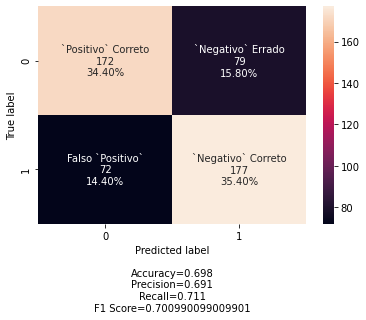

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

<hr>

## Scoring de la data requerida para hacer la entrega de la solución

Para el envío, necesita clasificar el siguiente dataset. Para hacer eso, usted necesita reproducir los mismos pasos de pre-procesamiento para que el dataset este en la misma estructura del que usted uso para construir su modelo. Despues de clasificar este dataframe, esperamos que usted entregue un archivo csv con las 2499 filar y una columna 'Graduado' con su predicción. **No cambie el orden del archivo a predecir ni borre filas**

In [29]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/for_submission/ToBePredicted.csv
df_to_be_predicted = pd.read_csv(r'ToBePredicted.csv')
df_to_be_predicted.tail()

--2020-09-10 03:08:23--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/for_submission/ToBePredicted.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33892 (33K) [text/plain]
Saving to: ‘ToBePredicted.csv’

ToBePredicted.csv   100%[===================>]  33.10K  --.-KB/s    in 0s      

2020-09-10 03:08:23 (80.0 MB/s) - ‘ToBePredicted.csv’ saved [33892/33892]



,studentId,reducido,ciclo
995,79594.0,Diagn. Psicoped.,2019 - 05
996,69470.0,Ventas Estrat.,2018 - 08
997,72921.0,Big Data,2019 - 02
998,80608.0,Interv. Psicoped,2019 - 05
999,86966.0,Interv. Psicoped,2019 - 07


In [30]:
# Uniendo los dataset
df = pd.merge(
    df_to_be_predicted, df_tabla_tareas, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)

# Eliminando la columna 'reducido'
df2 = df.drop(columns=['reducido'], inplace=False)

# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies``  (demontración)
df3 = pd.get_dummies(df2, columns=['ciclo'])
df3.tail()

,studentId,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,ciclo_2017 - 03,ciclo_2017 - 04,ciclo_2017 - 05,ciclo_2017 - 06,...,ciclo_2018 - 07,ciclo_2018 - 08,ciclo_2019 - 01,ciclo_2019 - 02,ciclo_2019 - 03,ciclo_2019 - 04,ciclo_2019 - 05,ciclo_2019 - 06,ciclo_2019 - 07,ciclo_2019 - 08
995,91291.0,0.000,0.0,12.0,0.0,12.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,91312.0,76.580,5.0,0.0,0.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,91329.0,86.410,13.0,0.0,0.0,13.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,91345.0,0.000,0.0,9.0,0.0,9.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
999,91437.0,75.024,15.0,0.0,0.0,15.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Observando los features declarados acontinuación, sabemos que el dataset ha ser evaluado esta en el mismo formato usado para entrenar nuestro árbol de decisión anteriormente.

```features = df3[
    [
        'studentId', 'Calificacion_Promedio', 'Tareas_Puntuales',
        'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
        'ciclo_2017 - 03', 'ciclo_2017 - 04', 'ciclo_2017 - 05',
        'ciclo_2017 - 06', 'ciclo_2017 - 07', 'ciclo_2017 - 08',
        'ciclo_2018 - 01', 'ciclo_2018 - 02', 'ciclo_2018 - 03',
        'ciclo_2018 - 04', 'ciclo_2018 - 05', 'ciclo_2018 - 06',
        'ciclo_2018 - 07', 'ciclo_2018 - 08', 'ciclo_2019 - 01',
        'ciclo_2019 - 02', 'ciclo_2019 - 03', 'ciclo_2019 - 04',
        'ciclo_2019 - 05', 'ciclo_2019 - 06', 'ciclo_2019 - 07',
        'ciclo_2019 - 08'
    ]
]
target = df3['Graduado']  ## No cambie la variable target!```

In [31]:
y_pred = dtc.predict(df3[
    [
        'studentId', 'Calificacion_Promedio', 'Tareas_Puntuales',
        'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
        'ciclo_2017 - 03', 'ciclo_2017 - 04', 'ciclo_2017 - 05',
        'ciclo_2017 - 06', 'ciclo_2017 - 07', 'ciclo_2017 - 08',
        'ciclo_2018 - 01', 'ciclo_2018 - 02', 'ciclo_2018 - 03',
        'ciclo_2018 - 04', 'ciclo_2018 - 05', 'ciclo_2018 - 06',
        'ciclo_2018 - 07', 'ciclo_2018 - 08', 'ciclo_2019 - 01',
        'ciclo_2019 - 02', 'ciclo_2019 - 03', 'ciclo_2019 - 04',
        'ciclo_2019 - 05', 'ciclo_2019 - 06', 'ciclo_2019 - 07',
        'ciclo_2019 - 08'
    ]
])
print(y_pred)

['No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'No' 'Si' 'Si' 'No' 'Si'
 'Si' 'No' 'No' 'No' 'Si' 'Si' 'No' 'No' 'Si' 'No' 'No' 'No' 'Si' 'Si'
 'No' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'No' 'No' 'Si' 'Si' 'Si' 'Si'
 'No' 'No' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'No'
 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'Si'
 'No' 'No' 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'Si'
 'Si' 'Si' 'No' 'Si' 'No' 'No' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'No'
 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'No' 'Si'
 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'Si'
 'No' 'Si' 'Si' 'No' 'Si' 'No' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'Si'
 'Si' 'No' 'No' 'Si' 'No' 'No' 'Si' 'No' 'No' 'No' 'No' 'Si' 'No' 'Si'
 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'No' 'Si' 'Si' 'No' 'Si' 'Si'
 'No' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'No'
 'Si' 'No' 'Si' 'No' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'No' 'Si' 'No' 'No'
 'No' 

# Guardando los resultados de la predicción en un archivo csv

In [166]:
#y_pred_ = model_sc.predict(df_test)
np.savetxt("envío/results.csv", y_pred, delimiter=",", fmt='%s')
#_ =pd.read_csv("envío/results.csv", header=None)
# y_pred = pd.DataFrame(data= y_pred_, columns=["Graduado"])
# df_final = df_test.join(y_pred)
# df_final.to_csv(path_or_buf= "envío/results.csv", index=False)

In [167]:
aaa = pd.read_csv("envío/results.csv", header=None)
aaa.to_csv(path_or_buf= "envío/results_.csv" , header=["TARGET"], index=False)

In [ ]:
#project.save_data(file_name="results.csv", data=pd.read_csv("results.csv", header=None).to_csv(header=["TARGET"], index=False))

<hr>

## ¡Felicitaciones!

Si todo fue ejecutado sin errores, usted ya tiene un modelo basado en classificacion binaria y puede descargar sus resultados para subirlos como csv!

Para enviar su solución, ve a la página:

# https://anahuac.maratona.dev
